# Advanced Lane Finding Project
* The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np                 # Matrix math
import cv2                         # OpenCV for image processing
import glob                        # Filename pattern matching
import pickle                      # Save and load data
import matplotlib.pyplot as plt    # Data visualization libary
import matplotlib.image as mpimg   # Image processing library
# Visualizations will be shown in the notebook
%matplotlib inline                 

In [ ]:
def save_pickle(mtx, dist):
    """ 
    Save pickled calibration data to be used in pipeline. 
    """
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))
    
def load_pickle():
    """
    Load pickled calibration data to be used in pipeline.
    """
    with open('wide_dist_pickle.p', 'rb') as f:
        dist_pickle = pickle.load(f)
        return dist_pickle['mtx'], dist_pickle['dist']

In [2]:
def calibration_points(img_path='camera_cal/calibration*.jpg'):
    """
    Reads file path to folder of chessboard images and returns their internal corners and
    corresponding 3D space objectpoints for future camera calibration.
    
    Parameters: img_path: path to chessboard image files
    Returns:  objpoints: array of 3D points for reference in distortion correction
              imgpoints: array of 2D points for distortion correction
    """
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plain

    # List of calibration images
    images = glob.glob(img_path)
    print('Num of calibration images: {0}'.format(len(images)))

    # Read each chessboard image and convert to grayscale
    for chessboard in images: 
        img = cv2.imread(chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Grayscale
        
        # Search for internal corners of chessboard, returns array of corner points
        # ret equals 0 if not all corners found or returned in wrong order
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None) 
        # If ret is non-zero, append object points and image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

In [3]:
def calibrate_camera(img):
    """
    Calibrates camera.
    Parameter: img: image file
    Returns: 
    """
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    objpoints, imgpoints = calibration_points()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Save the camera calibration result
    #save_pickle(mtx, dist)
    
    return mtx, dist

## Color Thresholding

In [4]:
# For universal plotting of results
def compare_images(img1, img2, title_1, title_2, grayscale=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if grayscale:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(title_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# Apply Sobel (Calculate directional gradient and apply gradient threshold)
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Return the magnitude of the gradient for a given sobel kernel 
# size and threshold values in both x and y
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Calculate gradient direction and apply threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use np.arctan2(abs_sobel_y, abs_sobimg_transel_x) to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

In [6]:
def combine_sobel_thresholds(img, visualize=False):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Sobel kernel size (choose a larger odd number to smooth gradient measurements)
    ksize = 7
    # Apply Sobel on x-axis
    grad_x_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    # Apply Sobel on y-axis
    grad_y_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    # Apply Sobel x and y, compute the magnitude of the gradient and apply a threshold
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 255))
    # Apply Sobel x and y, computes the direction of the gradient and apply a threshold
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.65, 1.05))
    
    # Combine the thresholds
    combined = np.zeros_like(dir_binary)
    combined[((grad_x_binary == 1) & (grad_y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if visualize:
        compare_images(image, grad_x_binary,      'Original Image (Undistorted)', 'Sobel on x-axis')
        compare_images(grad_y_binary, mag_binary, 'Sobel on y-axis', 'Thresholded Magnitude')
        compare_images(dir_binary, combined,      'Direction of gradient', 'Combined Thresholds')
    return combined

In [7]:
def color_channel_threshold(img, thresh=(0, 255), visualize=False):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract S channel
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    if visualize:
        compare_images(image, s_binary, 'Original Image (Undistorted)', 'HLS(S-channel) threshold')
    return s_binary

## Transform Perspective

In [8]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def perspective_transform(img, inv=False):
    # Define 4 source points
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    if inv == False:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    # Use cv2.warpPerspective() to warp image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

## Line Class

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # If line detected
        self.detected = False  
        # The x values of the last n fits
        self.recent_xfitted = collections.deque(12*[0.0, 0.0, 0.0], 12)
        # Mean x values of best fit line
        self.bestx = None
        # Mean polynomial coefficients 
        self.best_fit = None  
        # Polynomial coefficients for fit
        self.current_fit = [np.array([False])]  
        # Curvature radius of line in meters
        self.radius_of_curvature = None 
        # Meters from center of the line
        self.line_base_pos = None
        # Difference in old and new fit coefficients 
        self.diffs = np.array([0,0,0], dtype='float') 
        # The x values for detected line pixels
        self.allx = None
        # The y values for detected line pixels
        self.ally = None

## Pipeline

In [10]:
# COLOR / GRADIENT THRESHOLD
#mtx, dist = load_pickle()

def threshold(image, visual=False):
    
    # Undistort image
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    # Perform Sobel operations and combine thresholds
    combine_sobel = combine_sobel_thresholds(undist_image, visualize=visual)
    # Threshold color channel
    color_thresh = color_channel_threshold(undist_image, thresh=(160, 255), visualize=visual)
    # Combine color and gradient thresholds
    combined_binary = np.zeros_like(color_thresh)
    combined_binary[(combine_sobel == 1) | (color_thresh == 1)] = 1
    return combined_binary, undist_image

In [11]:
# PERSPECTIVE TRANSFORM
def warp(thresholded, visualize=False):
    # Run perspective transform function
    warped_img = perspective_transform(thresholded)
    
    # Define image mask (polygon of interest)
    imshape = warped_img.shape
    vertices = np.array([[(200, imshape[0]), (200, 0), (imshape[1] - 200, 0), 
                      (imshape[1]-200, imshape[0])]], dtype=np.int32)
    masked_img = region_of_interest(warped_img, vertices)
    if visualize:
        compare_images(warped_img, masked_img, 'Warped image', 'Warped image with mask')
    return masked_img

#### Detect Lane Lines

In [12]:
import collections

def find_base_pts(warped):
    # Take a histogram of the bottom half of the masked image
    histogram = np.sum(warped[warped.shape[0] // 2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

# DETECT LANE LINES
def detect_lines(warped):
    lines_detected = False
    
    # Find the starting point for the left and right lines
    midpoint, leftx_base, rightx_base = find_base_pts(warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255

    # Number of sliding windows
    nwindows = 9
    # Height of windows: e.g. 720/9=80
    window_height = np.int(warped.shape[0] / nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Sliding windows
    if (left_line.detected == False) or (right_line.detected == False) :
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window + 1) * window_height
            win_y_high = warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        left_line.detected = True
        right_line.detected = True
    else:
        left_lane_inds = ((nonzerox > (left_line.current_fit[0] * (nonzeroy**2) + 
                                       left_line.current_fit[1] * nonzeroy + 
                                       left_line.current_fit[2] - margin)) & 
                          (nonzerox < (left_line.current_fit[0] * (nonzeroy**2) + 
                                       left_line.current_fit[1] * nonzeroy + 
                                       left_line.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_line.current_fit[0] * (nonzeroy**2) + 
                                        right_line.current_fit[1] * nonzeroy + 
                                        right_line.current_fit[2] - margin)) & 
                           (nonzerox < (right_line.current_fit[0] * (nonzeroy**2) + 
                                        right_line.current_fit[1] * nonzeroy + 
                                        right_line.current_fit[2] + margin)))
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Here we need to save successful fit of lines to prevent case with empty x, y
    if (len(leftx) < 1500):
        leftx = left_line.allx
        lefty = left_line.ally
        left_line.detected = False
    else:
        left_line.allx = leftx
        left_line.ally = lefty
    if (len(rightx) < 1500):
        rightx = right_line.allx
        righty = right_line.ally
        right_line.detected = False
    else:
        right_line.allx = rightx
        right_line.ally = righty
    
    # Fit a second order polynomial to each
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Sanity check:
    # INIT
    if (left_line.current_fit[0] == False):
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
    
    if (abs(left_line.current_fit[1] - left_fit[1]) > 0.18):
        left_line.current_fit = left_line.best_fit
        left_line.detected = False
    else:
        left_line.current_fit = left_fit
        left_line.recent_xfitted.pop()
        left_line.recent_xfitted.appendleft(left_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_line.recent_xfitted:
            avg = avg + element
        left_line.best_fit = avg / (len(left_line.recent_xfitted))
        
    if (abs(right_line.current_fit[1] - right_fit[1]) > 0.18):
        right_line.current_fit = right_line.best_fit
        right_line.detected = False
    else:
        right_line.current_fit = right_fit
        right_line.recent_xfitted.pop()
        right_line.recent_xfitted.appendleft(right_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_line.recent_xfitted:
            avg = avg + element
        right_line.best_fit = avg / (len(right_line.recent_xfitted))
        
    if (abs(right_line.current_fit[1] - right_fit[1]) > 0.38 and
        abs(left_line.current_fit[1] - left_fit[1]) < 0.1):
        right_line.current_fit[0] = left_line.current_fit[0]
        right_line.current_fit[1] = left_line.current_fit[1]
        right_line.current_fit[2] = left_line.current_fit[2] + 600
        right_line.recent_xfitted.pop()
        right_line.recent_xfitted.appendleft(right_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_line.recent_xfitted:
            avg = avg + element
        right_line.best_fit = avg / (len(right_line.recent_xfitted))
        
    if (abs(left_line.current_fit[1] - left_fit[1]) > 0.38 and
        abs(right_line.current_fit[1] - right_fit[1]) < 0.1):
        left_line.current_fit = left_fit
        left_line.recent_xfitted.pop()
        left_line.recent_xfitted.appendleft(left_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_line.recent_xfitted:
            avg = avg + element
        left_line.best_fit = avg / (len(left_line.recent_xfitted))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0] )
    left_fitx = (left_line.current_fit[0] * ploty**2 + 
                 left_line.current_fit[1] * ploty + 
                 left_line.current_fit[2])
    right_fitx = (right_line.current_fit[0] * ploty**2 + 
                  right_line.current_fit[1] * ploty + 
                  right_line.current_fit[2])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx

### Offsets

In [13]:
# VEHICLE OFFSET FROM LANE CENTER
def calc_offset(xm_per_pix, ym_per_pix, y_eval, left_fit_cr, right_fit_cr):
    # Calculate x bottom position for y for left lane
    left_lane_bottom = (left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                        left_fit_cr[1] * (y_eval * ym_per_pix) + left_fit_cr[2])
    # Calculate x bottom position for y for right lane
    right_lane_bottom = (right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                         right_fit_cr[1] * (y_eval * ym_per_pix) + right_fit_cr[2])
    # Calculate the mid point of the lane
    lane_midpoint = float(right_lane_bottom + left_lane_bottom) / 2
    # Calculate the image center in meters from left edge of the image
    image_mid_point_in_meter = 1280/2 * xm_per_pix
    # Positive value indicates vehicle on the right side of lane center, else on the left.
    lane_deviation = (image_mid_point_in_meter - lane_midpoint)
    
    return lane_deviation

# MEASURE RADIUS OF CURVATURE AND VEHICLE OFFSET
def rad_and_offset(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = (((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2)**1.5) / 
                     np.absolute(2 * left_fit[0]))
    right_curverad = (((1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**1.5) / 
                      np.absolute(2 * right_fit[0]))
    curverad_avg = (left_curverad + right_curverad) / 2
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radius of curvature in meters
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + 
                           left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + 
                            right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    curverad_avg = (left_curverad + right_curverad) / 2
    # Vehicle offset
    lane_deviation = calc_offset(xm_per_pix, ym_per_pix, y_eval, left_fit_cr, right_fit_cr)
    
    return left_curverad, right_curverad, lane_deviation

## Draw Lanes

In [14]:
# DRAWING
def draw_res(warped, undistorted, out_img, ploty, left_fitx, right_fitx, left_curverad, right_curverad, lane_deviation):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warped, warped, warped))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, inv=True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    x_offset = result.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    result[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    curv_l_label = 'Radius of Curvature (Left line): {:.0f} m.'.format(left_curverad)
    curv_r_label = 'Radius of Curvature (Right line): {:.0f} m.'.format(right_curverad)
    deviation_label = 'Vehicle Deviation: {:.3f} m.'.format(lane_deviation)

    cv2.putText(result, curv_l_label, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(result, curv_r_label, (30, 110), font, 1, (255,255,255), 2)
    cv2.putText(result, deviation_label, (30, 160), font, 1, (255,255,255), 2)

    return result

In [15]:
def image_pipeline(image, v=False):
    # Threshold image
    thresholded, undistorted = threshold(image, visual=v)
    # Warp image
    warped = warp(thresholded, visualize=v)
    # Detect lane lines
    out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx = detect_lines(warped)
    # Radius of curvature for left and right lines
    left_curverad, right_curverad, lane_deviation = rad_and_offset(ploty, leftx, lefty, rightx, 
                                                                   righty, left_fit, right_fit)
    # Draw output
    proc_img = draw_res(warped, undistorted, out_img, ploty, left_fitx, right_fitx, 
                        left_curverad, right_curverad, lane_deviation)
    return proc_img

Num of calibration images: 20


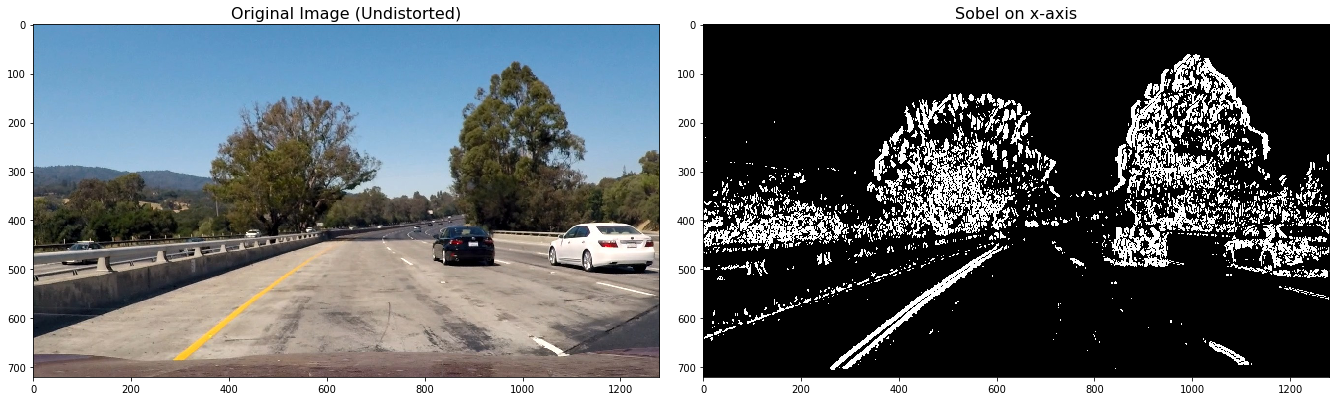

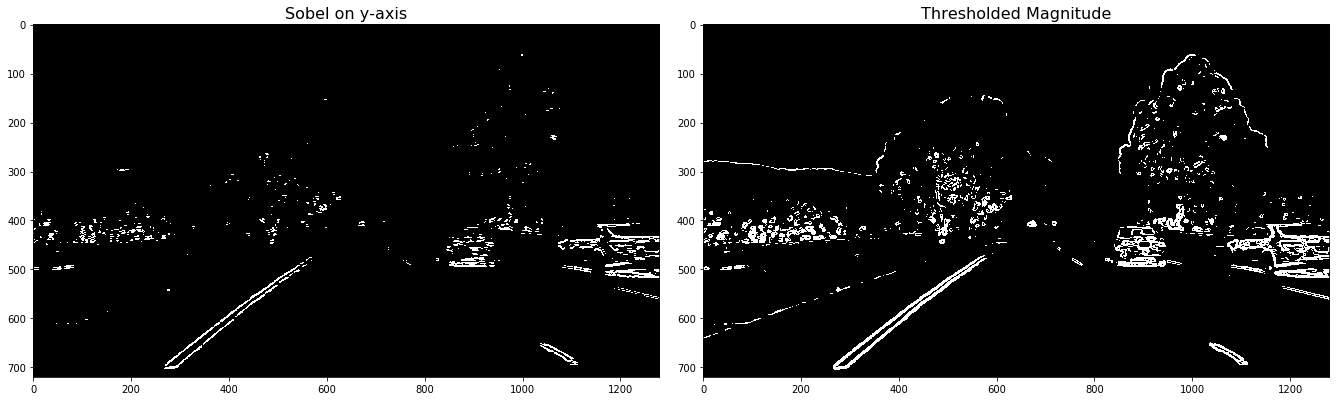

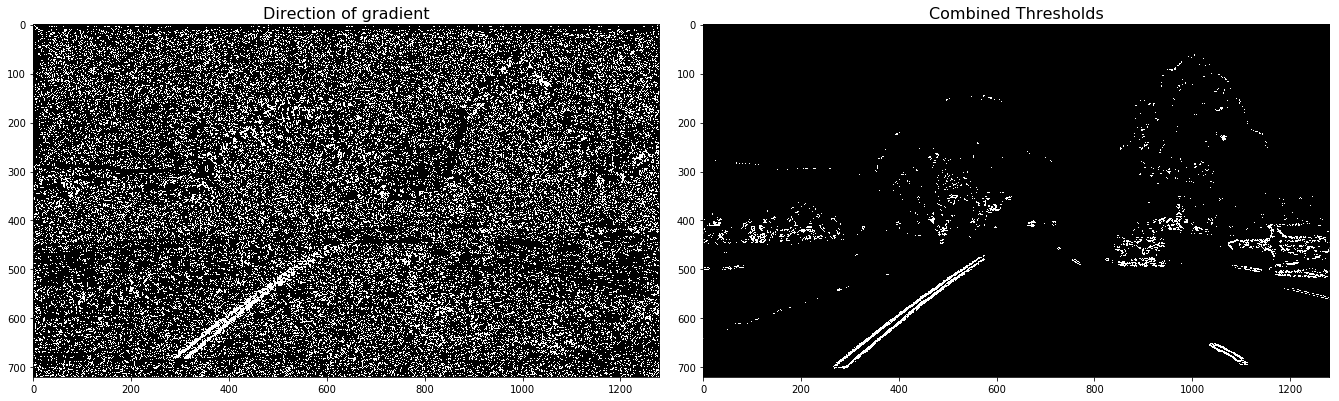

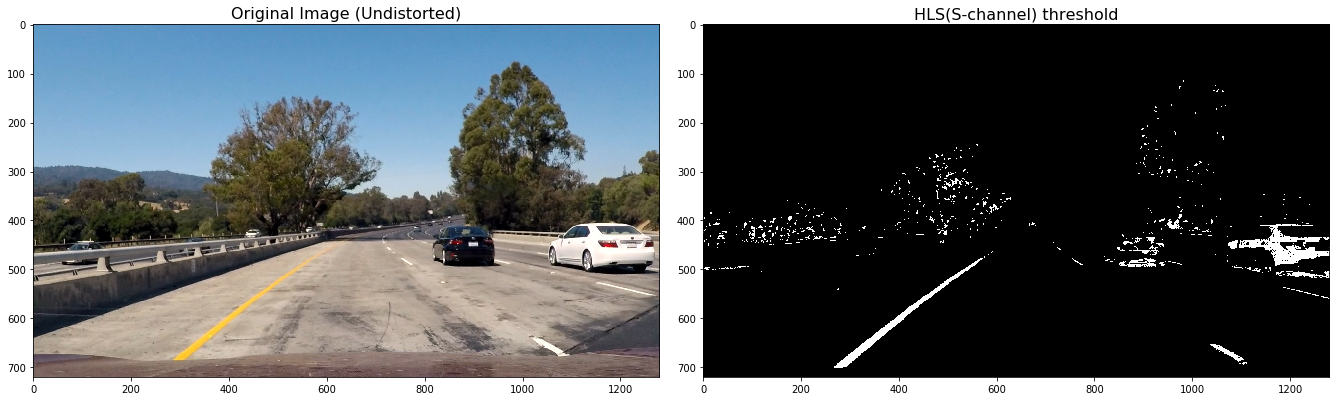

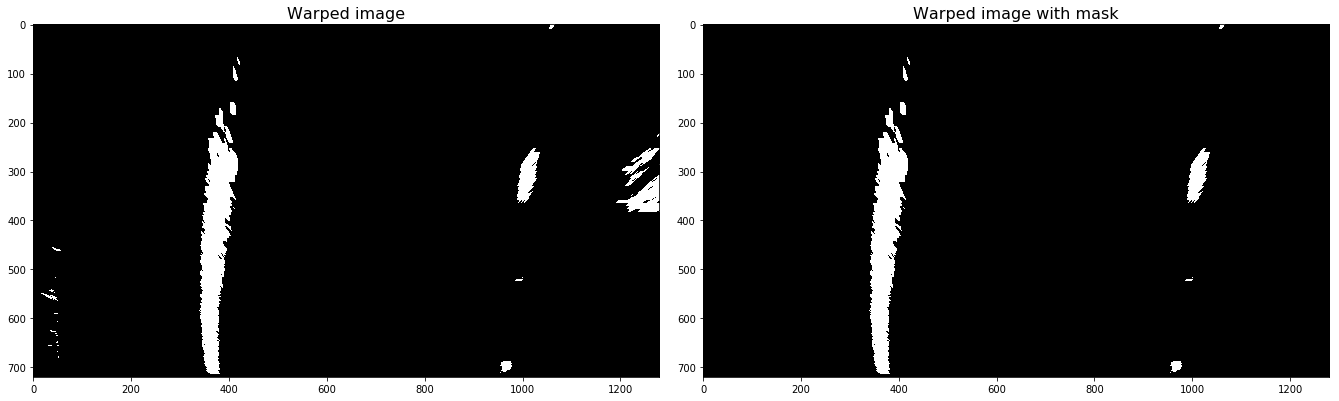

In [16]:
# MONITOR (FOR TESTING IMAGE PIPELINE)
# Load original image from camera
left_line = Line()
right_line = Line()
image = mpimg.imread('test_images/test1.jpg')
mtx, dist = calibrate_camera(image)
proc_img = image_pipeline(image, v=True)

In [17]:
# MONITOR (FOR TESTING VIDEO PIPELINE)
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
# Display video in notebook
from IPython.display import HTML

left_line = Line()
right_line = Line()
output_video = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,4)
video_clip = clip1.fl_image(image_pipeline)
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


 99%|█████████▉| 100/101 [01:14<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 54.5 s, sys: 11.7 s, total: 1min 6s
Wall time: 1min 18s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))